In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest

Parameters

In [9]:
eps = 2**-7
K = 9
J = 8
F = 10
hx = -0.8
hy = 1
dt = 2**-14
T_end = 2**9

### Integrate full L96 model

Uniform random initialization of X and Y

In [10]:
X_0 = 1-2*np.random.rand(K)
Y_0 = 1-2*np.random.rand(K,J)

RHS of X equation

In [11]:
def f(X,Y):
    B = hx*np.mean(Y, axis=1)
    dX = np.roll(X, 1)*(np.roll(X, -1) - np.roll(X, 2)) - X + F*np.ones(K) + B
    return dX

RHS of Y equation

In [12]:
def g(X,Y):
    dY = np.roll(Y,-1)*(np.roll(Y, 1) - np.roll(Y, -2)) - Y + hy*np.tile(X.reshape((K,1)), (1,J))
    dY *= 1/eps
    return dY

Integrate with RK-2 method

In [13]:
def RK_2(X_0, Y_0, N):
    X = np.zeros((K, N))
    Y = np.zeros((K, J, N))
    
    X[:,0] = X_0
    Y[:,:,0] = Y_0

    for n in range(1,N):
        # # Runge-Kutta 2 integration
        k1_X = dt * f(X[:,n-1], Y[:,:,n-1])
        k1_Y = dt * g(X[:,n-1], Y[:,:,n-1])
        
        k2_X = dt * f(X[:,n-1] + k1_X, Y[:,:,n-1] + k1_Y)
        k2_Y = dt * g(X[:,n-1] + k1_X, Y[:,:,n-1] + k1_Y)
        
        X[:,n] = X[:,n-1] + 0.5 * (k1_X + k2_X)
        Y[:,:,n] = Y[:,:,n-1] + 0.5 * (k1_Y + k2_Y)
    
    return X, Y


In [14]:
t_array = np.arange(0, T_end+dt, dt)
X_full, Y_full = RK_2(X_0, Y_0, len(t_array))

Save the outcomes with time resolution $Dt$ separately

In [15]:
X_full_coarse_dict = {}
for n in [-4, -6, -8, -10, -12]:
    Dt = 2**n
    stepsize = int(Dt/dt)
    X_full_coarse_dict[Dt] = X_full[:,::stepsize]    


In [55]:
# Dictionary to store reduced model solutions in
X_CMC_dict ={}

### Create reduced model

In [80]:
Dt = 2**-10
stepsize = int(Dt/dt)
X_full_coarse = X_full[:,::stepsize]
Y_full_coarse = Y_full[:,:,::stepsize]
B_full_coarse = hx*np.mean(Y_full_coarse, axis=1)
X_full_coarse_flattened = X_full_coarse.flatten()
B_full_coarse_flattened = B_full_coarse.flatten()

Create bins $I_{i}$ for $X_{k}$ 

In [82]:
X_bin_edges = np.arange(-4.5, 10.5)
N_bins_X = len(X_bin_edges) + 1
X_bin_edges

array([-4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,
        6.5,  7.5,  8.5,  9.5])

Create bins $\mathcal{J}^{i}_{n}$ for $B_k$

In [83]:
N_bins_B = 4
B_bins_edges = np.zeros((N_bins_X, N_bins_B-1))

X_coarse_flattened_bins = np.digitize(X_full_coarse_flattened, X_bin_edges)

for n in range(N_bins_X):
    X_bin_index = np.where(X_coarse_flattened_bins == n)
    B_coarse_flattened_bin = B_full_coarse_flattened[X_bin_index]
    bins = np.quantile(B_coarse_flattened_bin, np.linspace(0, 1, N_bins_B + 1))
    B_bins_edges[n,:] = bins[1:-1]

B_bins_edges

array([[ 0.81338955,  0.97222183,  1.1998389 ],
       [ 0.65143033,  0.78510006,  0.89410297],
       [ 0.56111075,  0.66094947,  0.74211475],
       [ 0.50361239,  0.56373867,  0.64766479],
       [ 0.34026889,  0.4432914 ,  0.55712781],
       [-0.24257924, -0.05602263,  0.12088236],
       [-0.75930021, -0.55684514, -0.39747945],
       [-1.08548147, -0.88039604, -0.71182302],
       [-1.39474638, -1.14428078, -0.91604107],
       [-1.72186249, -1.40555977, -1.11209749],
       [-2.03583924, -1.64052052, -1.30432834],
       [-2.22232064, -1.74613349, -1.3944493 ],
       [-2.45648704, -1.8559611 , -1.48102842],
       [-2.70965927, -1.99993757, -1.57565014],
       [-2.89746588, -2.16055521, -1.64783511],
       [-3.04125879, -2.34113467, -1.72693856]])

Calculate transition matrices

In [84]:
T = np.zeros((N_bins_X, N_bins_B, N_bins_X, N_bins_B))
for n in range(len(X_full_coarse_flattened)-1):
    X_n = X_full_coarse_flattened[n]
    B_n = B_full_coarse_flattened[n]
    X_n_bin = X_coarse_flattened_bins[n]
    B_n_bin = np.digitize(B_n, B_bins_edges[X_n_bin,:])
    B_n_next = B_full_coarse_flattened[n+1]
    X_n_next_bin = X_coarse_flattened_bins[n+1]
    B_n_next_bin = np.digitize(B_n_next, B_bins_edges[X_n_next_bin,:])
    T[X_n_bin, B_n_bin, X_n_next_bin, B_n_next_bin] += 1

In [85]:
P = np.zeros((N_bins_X, N_bins_B, N_bins_X, N_bins_B))
for i in range(N_bins_X):
    for n in range(N_bins_B):
        for j in range(N_bins_X):
            if np.sum(T[i,n,j,:]) != 0:
                for m in range(N_bins_B):
                    P[i,n,j,m] = T[i,n,j,m]/np.sum(T[i,n,j,:])
            else:
                P[i,n,j,n] = 1

Calculate $B$ averages in every bin $\mathcal{J}_{n}^{i}$

In [86]:
B_means = np.zeros((N_bins_X, N_bins_B))

for n in range(N_bins_X):
    B_n_bins_edges = B_bins_edges[n,:]
    X_bin_index = np.where(X_coarse_flattened_bins == n)
    B_coarse_flattened_bin = B_full_coarse_flattened[X_bin_index]
    B_k_bin_index = np.digitize(B_coarse_flattened_bin, B_n_bins_edges)
    for j in range(N_bins_B):
        B_k_bin_index_j = np.where(B_k_bin_index == j)
        B_means[n,j] = np.mean(B_coarse_flattened_bin[B_k_bin_index_j])

Scatter plots of $B_{k}$ versus $X_{k}$ for all $k\in[K]$, also showing the bins

Text(0, 0.5, '$B_{k}$')

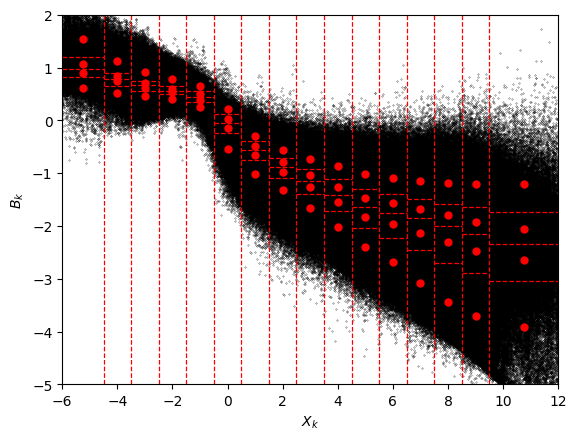

In [88]:
plt.scatter(X_full_coarse_flattened, B_full_coarse_flattened, s=0.05, c='black')


#Plot first  X bin and corresponding B bins
plt.axvline(X_bin_edges[0], linestyle="dashed", lw=0.9, color="red")
B_0_bins_edges = B_bins_edges[0,:]
X_bin_0_midpoint = (X_bin_edges[0]+ -6)/2
for m in range(N_bins_B-1):
    plt.hlines(y=B_0_bins_edges[m],
            xmin=-6,
            xmax=X_bin_edges[0],
            linestyle="dashed", 
            lw=0.9,
            colors="red"
    )
    plt.scatter(X_bin_0_midpoint, B_means[0,m], c='red', marker="o", s=25)
plt.scatter(X_bin_0_midpoint, B_means[0,m+1], c='red', marker="o", s=25)

#Plot the remaining bins
for n in range(1,N_bins_X-1):
    plt.axvline(X_bin_edges[n], linestyle="dashed", lw=0.9, color="red")
    B_n_bins_edges = B_bins_edges[n,:]
    X_bin_midpoint = (X_bin_edges[n]+ X_bin_edges[n-1])/2
    for m in range(N_bins_B-1):
        plt.hlines(y=B_n_bins_edges[m],
                   xmin=X_bin_edges[n-1],
                   xmax=X_bin_edges[n],
                   linestyle="dashed", 
                   lw=0.9,
                   colors="red"
        )
        
        plt.scatter(X_bin_midpoint, B_means[n,m], c='red', marker="o", s=25)
    plt.scatter(X_bin_midpoint, B_means[n,m+1], c='red', marker="o", s=25)
 
#Plot last X bin and corresponding B bins
B_last_bins_edges = B_bins_edges[-1,:]
X_bin_last_midpoint = (X_bin_edges[-1]+ 12)/2
for m in range(N_bins_B-1):
    plt.hlines(y=B_last_bins_edges[m],
            xmin=X_bin_edges[-1],
            xmax=12,
            linestyle="dashed", 
            lw=0.9,
            color="red",
    )
    plt.scatter(X_bin_last_midpoint, B_means[-1,m], c='red', marker="o", s=25)
plt.scatter(X_bin_last_midpoint, B_means[-1,m+1], c='red', marker="o", s=25)


plt.xlim((-6,12))
plt.ylim((-5,2))
plt.xlabel('$X_{k}$')
plt.ylabel('$B_{k}$')


Conditional Markov Chain integration

In [89]:
def G(X,B):
    dX = np.roll(X, 1)*(np.roll(X, -1) - np.roll(X, 2)) - X + F*np.ones(K) + B
    return dX

In [90]:
def CMC(X_0, B_0, N):
    X = np.zeros((K, N))
    B = np.zeros((K, N))
    
    X[:,0] = X_0
    B[:,0] = B_0

    for n in range(1,N):
        X_bin_current = np.digitize(X[:,n-1], X_bin_edges)
        B_bin_current = [np.digitize(B[k,n-1], B_bins_edges[X_bin_current,:][k,:]) for k in range(K)]

        # Runge-Kutta 2 integration
        k1 = Dt * G(X[:,n-1], B[:,n-1])
        k2 = Dt * G(X[:,n-1] + k1, B[:,n-1])
        X[:,n] = X[:,n-1] + 0.5*(k1+k2)

        X_bin_next = np.digitize(X[:,n], X_bin_edges)
        B_bin_next = [np.random.choice(N_bins_B, p=P[X_bin_current, B_bin_current, X_bin_next, :][k,:]) for k in range(K)]
        B[:,n] = B_means[X_bin_next, B_bin_next]
    return X

In [91]:
t_array_CMC = np.arange(0, T_end+Dt, Dt)
B_0 = hx*np.mean(Y_0, axis=1)
X_CMC_dict[Dt] = CMC(X_0, B_0, len(t_array_CMC))

Plotting of pdf's

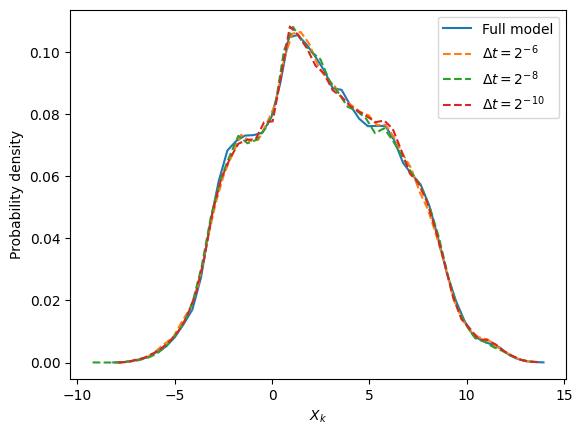

In [93]:
# Calculate the pdf
hist_full, bins_full = np.histogram(X_full.flatten(), bins=50, density=True)
bin_centers_full = (bins_full[:-1] + bins_full[1:]) / 2
pdf_full = hist_full 
plt.plot(bin_centers_full, pdf_full, label='Full model')

#Plot the pdf's
for n in [-6, -8, -10]:
    hist_CMC, bins_CMC = np.histogram(X_CMC_dict[2**n].flatten(), bins=50, density=True)
    bin_centers_CMC = (bins_CMC[:-1] + bins_CMC[1:]) / 2
    pdf_CMC = hist_CMC 
    plt.plot(bin_centers_CMC, pdf_CMC, label=rf'$\Delta t = 2^{{{n}}}$', linestyle='dashed')

plt.xlabel('$X_{k}$')
plt.ylabel('Probability density')
plt.legend()
plt.savefig("pdfs_varying_Delta_t.jpg", format="jpg", dpi=500)
plt.show()

Compute KS statistics

In [167]:

for n in [-4, -6, -8, -10, -12]:
    ks_stat, p_value = kstest(rvs=X_full.flatten(), cdf=X_CMC_dict[2**n].flatten())
    # Print the results
    print(f"delta_t:",n)
    print("KS statistic:", ks_stat)
    print("p-value:", p_value)

delta_t: -4
KS statistic: 0.008242767179874273
p-value: 8.938637450293101e-05
delta_t: -6
KS statistic: 0.006343616444359379
p-value: 1.0734319351709791e-10
delta_t: -8
KS statistic: 0.003288929361622339
p-value: 2.438042765263145e-11
delta_t: -10
KS statistic: 0.0040339917223067845
p-value: 3.368840510938824e-63
delta_t: -12
KS statistic: 0.004561795290145054
p-value: 2.352130220084027e-273


Correlation functions

In [94]:
def calculate_correlation(X_k, X_j):
  mu_X_k = X_k.mean()

  # Compute the full correlation and then only take the second half
  cor = np.correlate(X_k, X_j, mode='full')[len(X_k)-1:]
  
  # Create the array to subtract in a single step
  len_k = len(X_k)
  subtraction_array = np.arange(len_k, 0, -1) * mu_X_k**2
  cor -= subtraction_array
  
  # Create the divisor array
  divisor_array = np.arange(len_k, 0, -1)
  cor /= divisor_array
  
  # Normalize the correlation
  cor /= np.max(cor[:len_k//2])
  return cor

In [95]:
X_full_auto_cor_dict = {}
X_CMC_auto_cor_dict = {}

X_full_cross_cor_dict = {}
X_CMC_cross_cor_dict = {}

In [125]:
n = -10
Dt = 2**n
stop_full = int(T_end/dt)
stop_CMC = int(T_end/(2**n))

X_full_auto_cor = np.zeros((K, stop_CMC))
X_CMC_auto_cor = np.zeros((K, stop_CMC))
X_full_cross_cor = np.zeros((K, stop_CMC))
X_CMC_cross_cor = np.zeros((K, stop_CMC))


for k in range(K):
    X_full_auto_cor[k,:] = calculate_correlation(X_full_coarse[k,:], X_full_coarse[k,:])
    X_CMC_auto_cor[k,:] = calculate_correlation(X_CMC_dict[2**n][k,:stop_CMC], X_CMC_dict[2**n][k,:stop_CMC])

    X_full_cross_cor[k,:] = calculate_correlation(X_full_coarse[k,:], X_full_coarse[(k+1) % K,:])
    X_CMC_cross_cor[k,:] = calculate_correlation(X_CMC_dict[2**n][k,:stop_CMC], X_CMC_dict[2**n][(k+1) % K,:stop_CMC])

X_full_auto_cor_dict[Dt] = X_full_auto_cor
X_CMC_auto_cor_dict[Dt] = X_CMC_auto_cor
X_full_cross_cor_dict[Dt] = X_full_cross_cor
X_CMC_cross_cor_dict[Dt] = X_CMC_cross_cor



ValueError: could not broadcast input array from shape (524289,) into shape (524288,)

In [ ]:
t_array_CMC_dict = {}
for n in [-4, -6, -8, -10, -12]:
    Dt = 2**n
    t_array_CMC = np.arange(0, T_end+Dt, Dt)
    t_array_CMC_dict[Dt] = t_array_CMC

Text(0, 0.5, 'Autocorrelation')

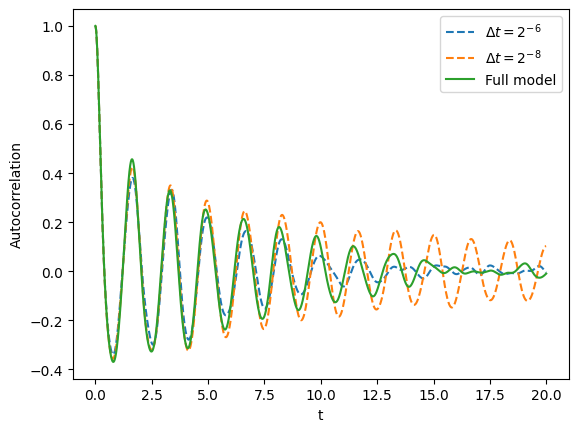

In [124]:
stop_plot_full = int(10/dt)     
for n in [-6, -8, -10]:
    stop_plot_CMC = int(10/(2**n)) 
    plt.plot(t_array_CMC_dict[2**n][:stop_plot_CMC], X_CMC_auto_cor_dict[2**n][:,:stop_plot_CMC].mean(axis=0), label=rf'$\Delta t = 2^{{{n}}}$', linestyle='dashed')

plt.plot(t_array[:stop_plot_full],X_full_auto_cor[:stop_plot_full], label="Full model")
plt.legend()
plt.xlabel("t")
plt.ylabel("Autocorrelation")

In [ ]:
stop_plot_full = int(10/dt)     
for n in [-6, -8]:
    stop_plot_CMC = int(10/(2**n)) 
    plt.plot(t_array_CMC_dict[2**n][:stop_plot_CMC], X_CMC_cross_cor_dict[2**n][:,:stop_plot_CMC].mean(axis=0), label=rf'$\Delta t = 2^{{{n}}}$', linestyle='dashed')

plt.plot(t_array[:stop_plot_full],X_full_auto_cor[:stop_plot_full], label="Full model")
plt.legend()
plt.xlabel("t")
plt.ylabel("Cross-correlation")